Create graphs that report performance of all 6 models

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils import print_log

In [2]:
expt_datetime_dict = {
    ("discrete", "0.0"): datetime(2025, 8, 13, 23, 23, 31),
    ("discrete", "0.5"): datetime(2025, 8, 14, 2, 5, 26),
    ("discrete", "1.0"): datetime(2025, 8, 14, 4, 46, 19),
    ("continuous", "0.0"): datetime(2025, 8, 11, 2, 46, 31),
    ("continuous", "0.5"): datetime(2025, 8, 11, 4, 45, 55),
    ("continuous", "1.0"): datetime(2025, 8, 11, 6, 42, 39),
}

In [3]:
expt_folders = {
    k: Path("experiments") / (v.strftime("%Y%m%d_%H%M%S") + "_action_" + k[0] + "_reward_lambda_" + k[1]) for k, v in expt_datetime_dict.items()
}

# check if all folders exist
for folder in expt_folders.values():
    if not folder.exists():
        print_log(f"Experiment folder {folder} does not exist. Please check the experiment datetime and action type.")
        raise FileNotFoundError(f"Experiment folder {folder} does not exist.")
    else:
        print_log(f"Experiment folder {folder} exists.")
    
expt_train_folders = {
    k: v / ("logs_train") for k, v in expt_folders.items()
}

[2025-08-25 18:56:09:344] Experiment folder experiments/20250813_232331_action_discrete_reward_lambda_0.0 exists.
[2025-08-25 18:56:09:344] Experiment folder experiments/20250814_020526_action_discrete_reward_lambda_0.5 exists.
[2025-08-25 18:56:09:344] Experiment folder experiments/20250814_044619_action_discrete_reward_lambda_1.0 exists.
[2025-08-25 18:56:09:344] Experiment folder experiments/20250811_024631_action_continuous_reward_lambda_0.0 exists.
[2025-08-25 18:56:09:344] Experiment folder experiments/20250811_044555_action_continuous_reward_lambda_0.5 exists.
[2025-08-25 18:56:09:344] Experiment folder experiments/20250811_064239_action_continuous_reward_lambda_1.0 exists.


In [4]:
output_folder = Path("experiments_graphs")

if not output_folder.exists():
    output_folder.mkdir(parents=True)

In [5]:
def load_all_h_network_training_losses(expt_train_folders):
    """
    Load h-network training loss data from all experiment training folders.
    
    Args:
        expt_train_folders: dict with keys (action_space, lambda_value) and values as Path objects
                           to training folders containing h_network_train_loss_list.json files
    
    Returns:
        dict: Same keys as input, values are DataFrames containing h-network training losses
    """
    all_results = {}
    
    for key, expt_train_folder in expt_train_folders.items():
        print_log(f"Loading h-network training loss data for experiment {key}: {expt_train_folder}")
        
        # Load h-network training loss data
        h_network_loss_list_path = expt_train_folder / "h_network_train_loss_list.json"
        
        if h_network_loss_list_path.exists():
            with open(h_network_loss_list_path, "r") as f:
                h_network_loss_data = json.load(f)
                h_network_loss_list = h_network_loss_data['train_loss_list']

            # Convert the list to a DataFrame
            h_network_loss_df = pd.DataFrame(h_network_loss_list)
            
            print_log(f"Loaded h-network training loss data for {key}: {len(h_network_loss_df)} training steps")
            print_log(f"H-network loss DataFrame shape for {key}: {h_network_loss_df.shape}")
            
            all_results[key] = h_network_loss_df
            
        else:
            print_log(f"H-network loss file {h_network_loss_list_path} does not exist for {key}.")
            all_results[key] = None
    
    return all_results

In [6]:
# Load all h-network training loss data from experiment folders
all_h_network_losses = load_all_h_network_training_losses(expt_train_folders)

# Display summary of loaded data
for key, h_network_loss_df in all_h_network_losses.items():
    if h_network_loss_df is not None:
        print_log(f"Experiment {key}: {len(h_network_loss_df)} training steps loaded")
        if len(h_network_loss_df) > 0:
            print_log(f"  Columns: {list(h_network_loss_df.columns)}")
            print_log(f"  Training steps range: {h_network_loss_df.index.min()} to {h_network_loss_df.index.max()}")
    else:
        print_log(f"Experiment {key}: No h-network loss data found")

[2025-08-25 18:56:09:371] Loading h-network training loss data for experiment ('discrete', '0.0'): experiments/20250813_232331_action_discrete_reward_lambda_0.0/logs_train
[2025-08-25 18:56:09:372] Loaded h-network training loss data for ('discrete', '0.0'): 161 training steps
[2025-08-25 18:56:09:372] H-network loss DataFrame shape for ('discrete', '0.0'): (161, 3)
[2025-08-25 18:56:09:372] Loading h-network training loss data for experiment ('discrete', '0.5'): experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train
[2025-08-25 18:56:09:374] Loaded h-network training loss data for ('discrete', '0.5'): 161 training steps
[2025-08-25 18:56:09:374] H-network loss DataFrame shape for ('discrete', '0.5'): (161, 3)
[2025-08-25 18:56:09:374] Loading h-network training loss data for experiment ('discrete', '1.0'): experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train
[2025-08-25 18:56:09:374] Loaded h-network training loss data for ('discrete', '1.0'): 161

In [7]:
def plot_cross_model_h_network_losses(all_h_network_losses, show=True, save_path=None):
    """
    Plots h-network training losses for all models with mean loss and optional standard deviation plots.
    
    Args:
        all_h_network_losses: dict with keys (action_space, lambda_value) and values as DataFrames containing h-network losses
        show: bool, whether to show plot (default: True)
        save_path: str or None, path to save figure (default: None)
    """
    
    # Extract loss data for each experiment
    model_loss_dict = {}
    has_std_data = False
    
    for key, h_network_loss_df in all_h_network_losses.items():
        if h_network_loss_df is not None and len(h_network_loss_df) > 0:
            action_space, lambda_value = key
            
            # Check for required columns
            if 'mean_loss' in h_network_loss_df.columns:
                # Map action space to algorithm name
                algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
                model_loss_dict[key] = {
                    'mean_loss': h_network_loss_df['mean_loss'].values,
                    'std_loss': h_network_loss_df['std_loss'].values if 'std_loss' in h_network_loss_df.columns else None,
                    'label': f'{algo_name} λ={lambda_value}'
                }
                
                if 'std_loss' in h_network_loss_df.columns:
                    has_std_data = True
    
    if not model_loss_dict:
        print_log("No valid h-network loss data found for plotting.")
        return None
    
    # Assign colors for each lambda value using tab10 palette
    unique_lambdas = sorted(set([k[1] for k in model_loss_dict.keys()]))
    base_palette = sns.color_palette('tab10', n_colors=len(unique_lambdas))
    lambda_color_map = {lam: base_palette[i] for i, lam in enumerate(unique_lambdas)}
    
    # For each lambda, create saturated (continuous) and pale (discrete) variants
    def adjust_color(color, saturation):
        # Simple saturation adjustment: interpolate towards white
        return tuple([saturation * c + (1-saturation) * 1.0 for c in color])
    
    action_space_saturation = {'continuous': 1.0, 'discrete': 0.5}
    
    # Create subplots: mean loss (always), std loss (if data available)
    if has_std_data:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=150)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 6), dpi=150)
        ax2 = None
    
    # Plot mean losses
    for (action_space, lambda_value), result in model_loss_dict.items():
        mean_loss = result['mean_loss']
        std_loss = result['std_loss']
        label = result['label']
        
        color_base = lambda_color_map[lambda_value]
        color = adjust_color(color_base, action_space_saturation[action_space])
        
        # Plot mean loss curve
        episode_indices = np.arange(len(mean_loss))
        ax1.plot(episode_indices, mean_loss, color=color, linewidth=2, label=label)
        
        # Plot std loss curve if available and subplot exists
        if std_loss is not None and ax2 is not None:
            ax2.plot(episode_indices, std_loss, color=color, linewidth=2, label=label)
    
    # Configure mean loss subplot
    ax1.set_xlabel('Number of updates')
    ax1.set_ylabel('Mean H-Network Loss')
    ax1.set_title('Cross-Model H-Network Training: Mean Loss')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Configure std loss subplot if it exists
    if ax2 is not None:
        ax2.set_xlabel('Number of updates')
        ax2.set_ylabel('Std H-Network Loss')
        ax2.set_title('Cross-Model H-Network Training: Standard Deviation Loss')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"H-network loss plot saved to: {save_path}")
    
    if show:
        plt.show()
    
    # Print summary statistics
    print_log("\nH-Network Training Loss Summary:")
    for (action_space, lambda_value), result in model_loss_dict.items():
        mean_loss = result['mean_loss']
        final_mean = mean_loss[-1] if len(mean_loss) > 0 else 0
        min_mean = np.min(mean_loss) if len(mean_loss) > 0 else 0
        print_log(f"{result['label']}: {len(mean_loss)} training steps, Final mean loss: {final_mean:.6f}, Min mean loss: {min_mean:.6f}")
        
        if result['std_loss'] is not None:
            std_loss = result['std_loss']
            final_std = std_loss[-1] if len(std_loss) > 0 else 0
            min_std = np.min(std_loss) if len(std_loss) > 0 else 0
            print_log(f"  Final std loss: {final_std:.6f}, Min std loss: {min_std:.6f}")
    
    return fig

[2025-08-25 18:56:09:568] H-network loss plot saved to: experiments_graphs/cross_model_h_network_losses.svg


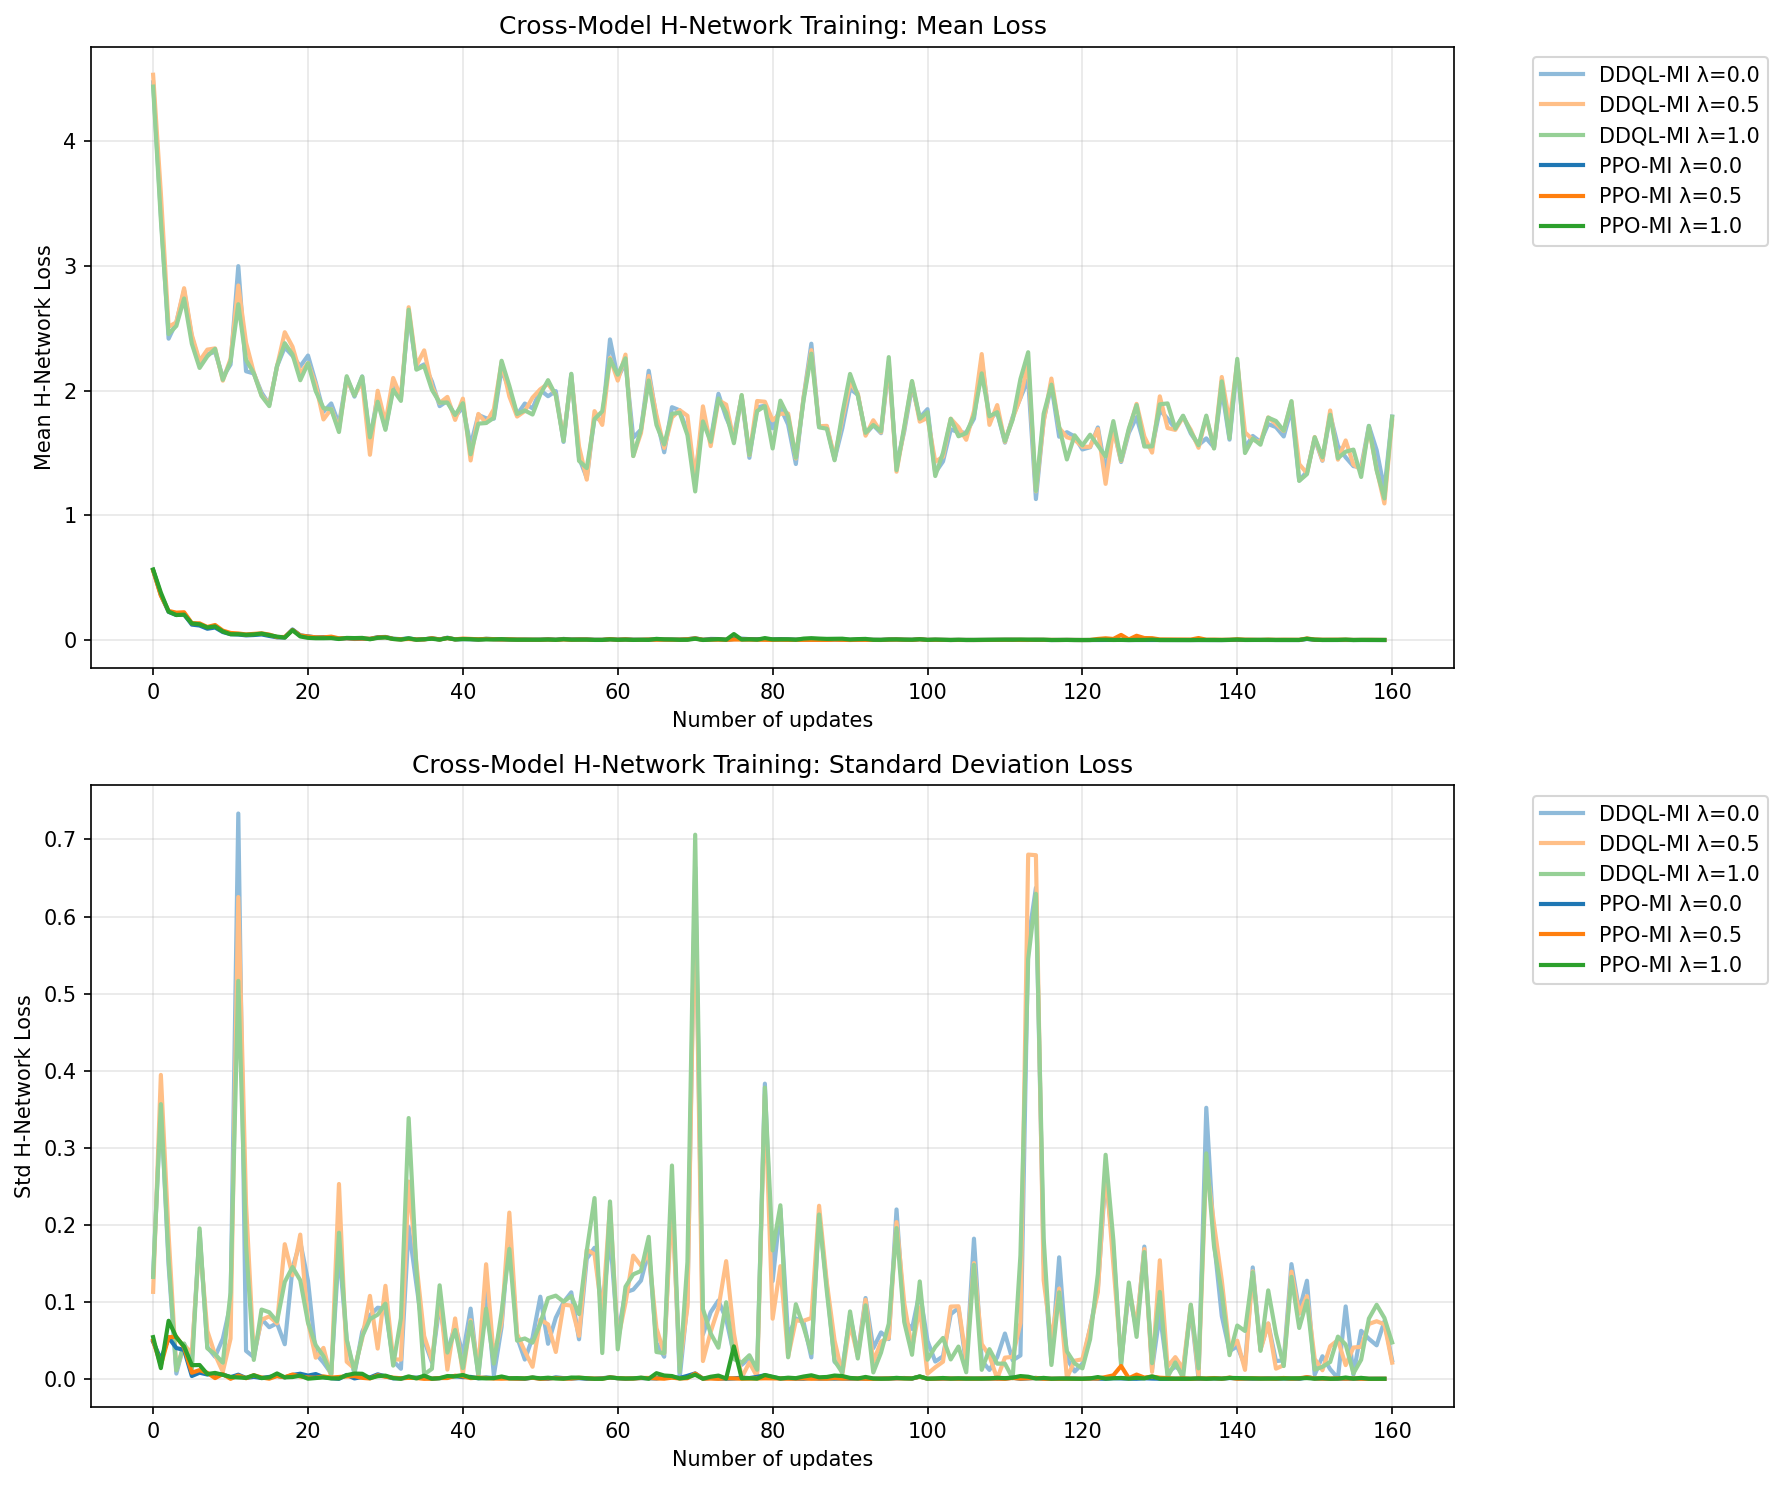

[2025-08-25 18:56:09:721] 
H-Network Training Loss Summary:
[2025-08-25 18:56:09:721] DDQL-MI λ=0.0: 161 training steps, Final mean loss: 1.791096, Min mean loss: 1.130333
[2025-08-25 18:56:09:721]   Final std loss: 0.024011, Min std loss: 0.000151
[2025-08-25 18:56:09:721] DDQL-MI λ=0.5: 161 training steps, Final mean loss: 1.760856, Min mean loss: 1.095358
[2025-08-25 18:56:09:721]   Final std loss: 0.021002, Min std loss: 0.000290
[2025-08-25 18:56:09:721] DDQL-MI λ=1.0: 161 training steps, Final mean loss: 1.789782, Min mean loss: 1.135562
[2025-08-25 18:56:09:721]   Final std loss: 0.047216, Min std loss: 0.000700
[2025-08-25 18:56:09:721] PPO-MI λ=0.0: 160 training steps, Final mean loss: 0.000981, Min mean loss: 0.000468
[2025-08-25 18:56:09:721]   Final std loss: 0.000022, Min std loss: 0.000001
[2025-08-25 18:56:09:721] PPO-MI λ=0.5: 160 training steps, Final mean loss: 0.001387, Min mean loss: 0.000776
[2025-08-25 18:56:09:721]   Final std loss: 0.000087, Min std loss: 0.0000

In [8]:
# Test the cross-model h-network loss plot
fig_h_loss = plot_cross_model_h_network_losses(
    all_h_network_losses, 
    show=True,
    # save_path=None 
    save_path=output_folder / "cross_model_h_network_losses.svg"
)